In [31]:
import autograd.numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
import seaborn as sb

# local imports
from train.dataloader import create_datasets_sim
from train.model import vgg13bn, vggSmall, vgg11
from train.train import train_model
from train.losses import weighted_MSEloss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

%reload_ext autoreload
%autoreload 2

device: cpu


# State prediction
The psysical system can at a given time $t$ be at a state described by $a$ and $b$. A measurement record $X_i$ of $m$ measurements therefore has the shape $X_i \in \reals^{m}$ and the state of the system is descriped by $\boldsymbol{\rho} = [\mathbf{a}, \mathbf{b}] \in \reals^{m \times 2}$. The whole dataset then consists of $N$ such records $\mathcal{D} = ((\boldsymbol{\rho}_i, X_i), \ldots, (\boldsymbol{\rho}_N), X_N)$. The task is then from $X_i$ to predic the state $\boldsymbol{\rho}_i$. First the task is performed on measurement records that has reached a steady state, and then on records with varying states. 

Firstly we will consider a simple physical model where the state is described by a only by the posible class $a_i\in \reals^n$, the task then becomes a regression task. 

torch.Size([500, 61])


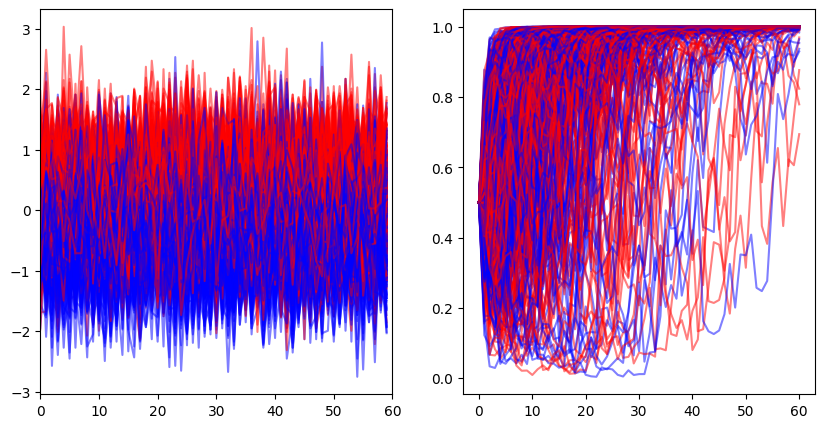

In [3]:
# psysical model parameters
N = 60 # NOTE: must be fixed for the CNN
g = 0.25
a0 = 1/np.sqrt(2)

# data
N_data = 500
test_dataset  =  create_datasets_sim(N_data, 1, N=N, g=g, a0=a0)
Xtest, ytest, atest, btest = test_dataset.tensors

# plot some examples from the dataset
Xtest, ytest, atest, btest = test_dataset.tensors
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(Xtest.shape[0]):
    X = Xtest[i].numpy()
    label = ytest[i].item()
    if label == 0:
        axes[0].plot(range(X.shape[-1]), X.squeeze(0), color='blue', alpha=0.5)
    else:
        axes[0].plot(range(X.shape[-1]), X.squeeze(0), color='red', alpha=0.5)


axes[0].set_xlim([0, N])
axes[0].set_xticks(range(0, N+1, 10))

print(atest.shape)
# plot the a and b
for i in range(atest.shape[0]):
    label = ytest[i].item()
    if label == 1:
        axes[1].plot(range(N+1), atest[i].numpy()**2, label= 'a', color = 'blue', alpha=0.5)
    else:
        axes[1].plot(range(N+1), btest[i].numpy()**2, label= 'b', color = 'red', alpha=0.5)

plt.show()


Define the validation and train set

In [4]:
batch_size = 128

# train and val dataset
train_dataset, val_dataset =  create_datasets_sim(N_data,0.8, N=N, g=g, a0=a0)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Find weight for weighed mse loss

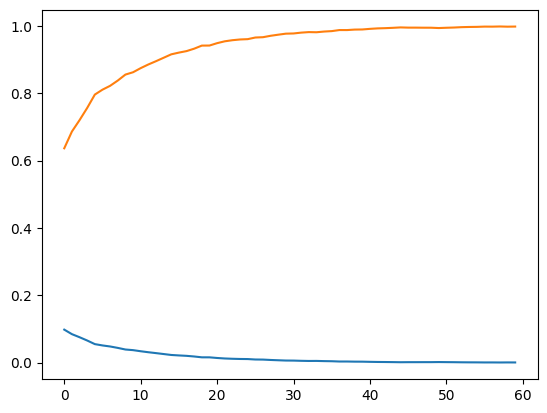

In [28]:
find_probs = lambda a, b: np.maximum(a**2, b**2).mean(axis=0)

# train data
Xtrain, ytrain, atrain, btrain = train_dataset.tensors
probs = find_probs(atrain, btrain)
# 1 - prob of being in the class
weights = 1 - probs[1:]
weights = weights/weights.sum() # normalize
plt.plot(range(N), weights, label= 'weights')
plt.plot(range(N), probs[1:], label= 'probs')
plt.show()

In [37]:
weights

tensor([0.0980, 0.0846, 0.0755, 0.0657, 0.0550, 0.0511, 0.0480, 0.0438, 0.0390,
        0.0372, 0.0339, 0.0310, 0.0283, 0.0256, 0.0228, 0.0214, 0.0202, 0.0183,
        0.0158, 0.0158, 0.0139, 0.0124, 0.0115, 0.0109, 0.0107, 0.0094, 0.0091,
        0.0080, 0.0071, 0.0063, 0.0061, 0.0055, 0.0050, 0.0052, 0.0046, 0.0042,
        0.0034, 0.0034, 0.0030, 0.0029, 0.0024, 0.0021, 0.0019, 0.0016, 0.0013,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0018, 0.0016, 0.0014, 0.0011, 0.0009,
        0.0008, 0.0006, 0.0007, 0.0005, 0.0007, 0.0006])

In [36]:
# weighted MSE loss
loss_fn = weighted_MSEloss(weights = weights)

# test the loss function
a = torch.randn(1, N+1)
b = torch.randn(1, N+1)

loss = loss_fn(a, b)


TypeError: super(type, obj): obj must be an instance or subtype of type

## Neural network - CNN
The neural network is a simple convolutional neural network. Here a has the shape $n+1$ so i remove the first element so it has the same shape as the input

In [15]:
# hyperparameters
num_epochs = 20
lr = 1e-4

# define model
model = vgg13bn(num_classes = N)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# weighted MSE loss
loss_fn = weighted_loss(weights)

# train the model
#model, stat = train_model(model, train_loader, val_loader, N, num_epochs, loss_fn, optimizer, device ,steady_state=False, verbose = False)


Performance

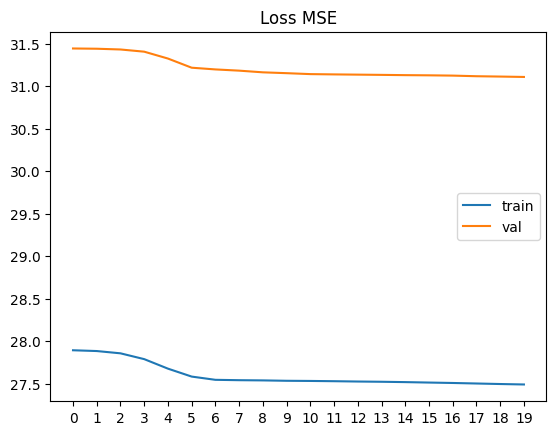

In [16]:
plt.figure()
plt.title('Loss MSE')
plt.plot(range(num_epochs), stat['train_loss'], label = 'train')
plt.plot(range(num_epochs), stat['val_loss'], label = 'val')
plt.xticks(range(num_epochs))
plt.legend()
plt.show()


Predictions

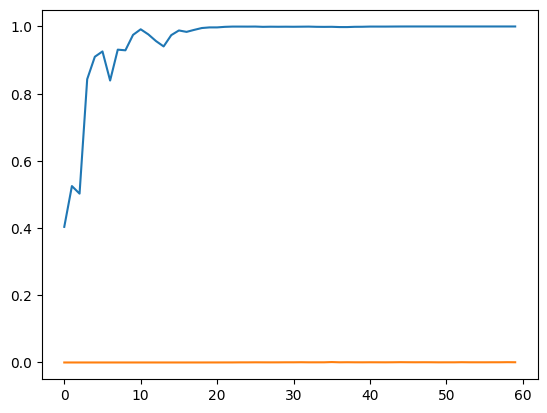

In [18]:
Xtest, ytest, atest, btest = test_dataset.tensors

# get the predictions on a signle record
idx = 0
X = Xtest[idx].unsqueeze(0)
y = ytest[idx].item()
a = atest[idx]
b = btest[idx]

model.eval()
with torch.no_grad():
    pred = model(X).squeeze().numpy()


plt.figure()
plt.plot(range(N), a[1:].numpy()**2, label='a')
plt.plot(range(N), pred**2)
plt.show()

